In [1]:
!pip install ortools
from ortools.sat.python import cp_model # CP-SAT solver

import numpy as np
from random import randint
from math import ceil
import matplotlib.pyplot as plt # Data visualization
plt.rcParams["figure.figsize"] = (15,10)

  Using cached protobuf-6.31.1-cp310-abi3-win_amd64.whl.metadata (593 bytes)
   ---------------------------------------- 0.0/20.5 MB ? eta -:--:--
    --------------------------------------- 0.3/20.5 MB ? eta -:--:--
   -- ------------------------------------- 1.0/20.5 MB 3.3 MB/s eta 0:00:06
   --- ------------------------------------ 1.8/20.5 MB 3.5 MB/s eta 0:00:06
   ----- ---------------------------------- 2.6/20.5 MB 3.7 MB/s eta 0:00:05
   ----- ---------------------------------- 2.9/20.5 MB 3.6 MB/s eta 0:00:05
   ------ --------------------------------- 3.1/20.5 MB 3.0 MB/s eta 0:00:06
   ------ --------------------------------- 3.4/20.5 MB 2.7 MB/s eta 0:00:07
   ------- -------------------------------- 3.7/20.5 MB 2.3 MB/s eta 0:00:08
   ------- -------------------------------- 3.9/20.5 MB 2.2 MB/s eta 0:00:08
   -------- ------------------------------- 4.2/20.5 MB 2.1 MB/s eta 0:00:08
   -------- ------------------------------- 4.5/20.5 MB 2.0 MB/s eta 0:00:09
   --------- 

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
googleapis-common-protos 1.69.1 requires protobuf!=4.21.1,!=4.21.2,!=4.21.3,!=4.21.4,!=4.21.5,<6.0.0.dev0,>=3.20.2, but you have protobuf 6.31.1 which is incompatible.
google-ai-generativelanguage 0.6.15 requires protobuf!=4.21.0,!=4.21.1,!=4.21.2,!=4.21.3,!=4.21.4,!=4.21.5,<6.0.0dev,>=3.20.2, but you have protobuf 6.31.1 which is incompatible.
grpcio-status 1.71.0 requires protobuf<6.0dev,>=5.26.1, but you have protobuf 6.31.1 which is incompatible.

[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


# Parameters

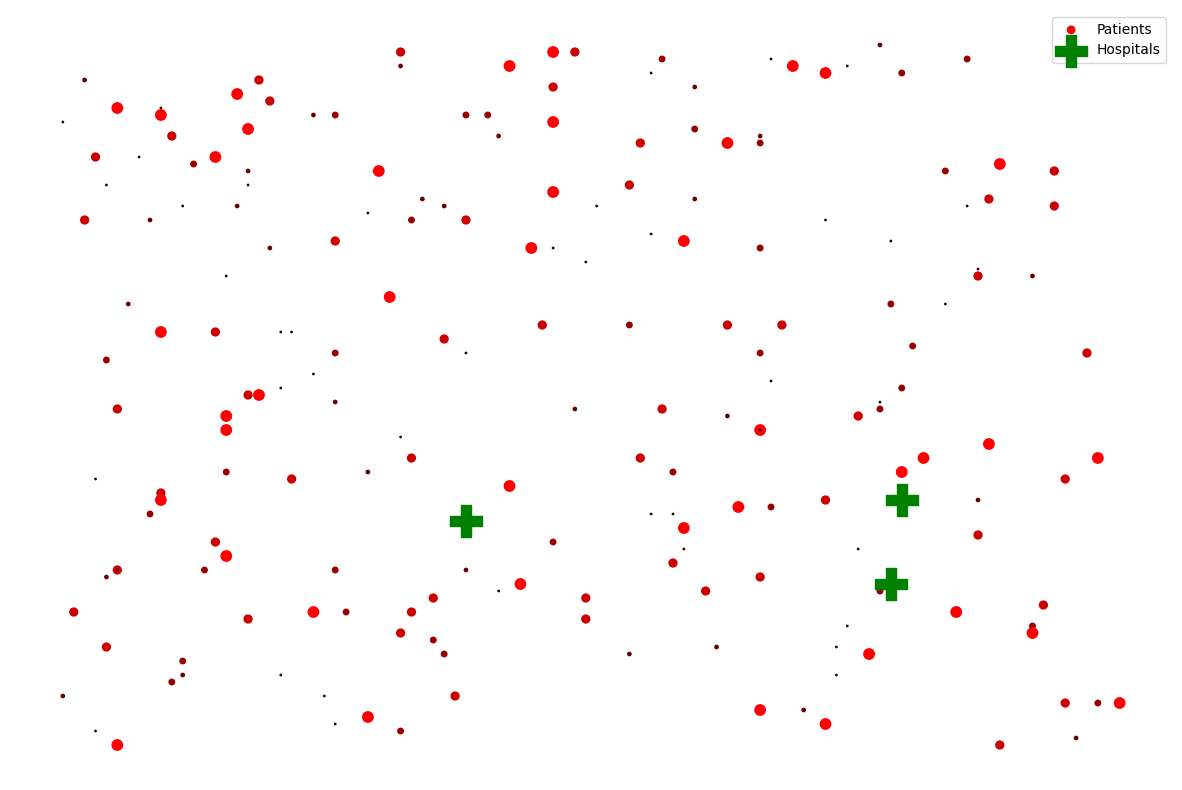

In [2]:
# Number of hospitals
n_hospitals = 3
# Number of patients
n_patients = 200
# Number of beds in every hospital
n_beds_in_hospitals = [30,40,15]
# Total number of beds
n_beds_total = sum(n_beds_in_hospitals)
# Location of patients -- random integer tuple (x,y)
patients_loc = [(randint(0, 100), randint(0, 100)) for _ in range(n_patients)]
# Location of hospitals -- random integer tuple (x,y)
hospitals_loc = [(randint(0, 100), randint(0, 100)) for _ in range(n_hospitals)]
# Illness severity -- 1 = mild -> 5 = severe
patients_severity = [randint(1, 5) for _ in range(n_patients)]

# Visualization
shade_severity = [int(sev*255/5) for sev in patients_severity]
color_severity = ["#%02x0000" % (sev) for sev in shade_severity]
size_severity = [k**2.5 for k in patients_severity]
plt.scatter(*zip(*patients_loc), s=size_severity, c=color_severity, label="Patients")
plt.scatter(*zip(*hospitals_loc), s=500, c="g", marker="P", label="Hospitals")
plt.legend()
plt.axis('off')
plt.show()

# Model variables



In [3]:
model = cp_model.CpModel()
x = {}
for i in range(n_hospitals):
  for j in range(n_beds_in_hospitals[i]):
    for k in range(n_patients):
      x[(i,j,k)] = model.NewBoolVar("x(%d,%d,%d)" % (i,j,k))

# Hard constraints

In [4]:
# Each bed must host at most one person
for i in range(n_hospitals):
  for j in range(n_beds_in_hospitals[i]):
    model.Add(sum(x[(i,j,k)] for k in range(n_patients)) <= 1)


# Each person must be placed in at most one bed
for k in range(n_patients):
  inner_sum = []
  for i in range(n_hospitals):
    inner_sum.append(sum(x[(i,j,k)] for j in range(n_beds_in_hospitals[i])))
  model.Add(sum(inner_sum) <= 1)

# Soft constraints

In [5]:
# Integer distance function
idist = lambda xy1, xy2: int(((xy1[0]-xy2[0])**2 + (xy1[1]-xy2[1])**2)**0.5)

# Gain factors (1/penalty factors)
gain_max_patients = 140
gain_severity = int(140/5)
gain_distance = -1

# Maximization objective
soft_csts = []
for i in range(n_hospitals):
  for j in range(n_beds_in_hospitals[i]):
    for k in range(n_patients):
      factor = \
        gain_max_patients \
        + gain_distance * idist(hospitals_loc[i], patients_loc[k]) \
        + gain_severity * patients_severity[k]
      soft_csts.append(factor * x[(i,j,k)])

model.Maximize(sum(soft_csts))

# Solving model

In [6]:
solver = cp_model.CpSolver()
solver.parameters.max_time_in_seconds = 60.0
status = solver.Solve(model)

# Priting results

In [7]:
plot_lines = [[] for _ in range(n_hospitals)]
for i in range(n_hospitals):
  print("Hospital ", i)
  for j in range(n_beds_in_hospitals[i]):
    for k in range(n_patients):
      if solver.Value(x[(i,j,k)]) == 1:
        print("\tPatient ", k, "in bed ", j)
        line_abs = [ hospitals_loc[i][0], patients_loc[k][0] ]
        line_ord = [ hospitals_loc[i][1], patients_loc[k][1] ]
        plot_lines[i].append([line_abs, line_ord])
print()
print("Inference time: %f s" % solver.WallTime())

Hospital  0
	Patient  76 in bed  0
	Patient  171 in bed  1
	Patient  195 in bed  2
	Patient  93 in bed  3
	Patient  90 in bed  4
	Patient  138 in bed  5
	Patient  193 in bed  6
	Patient  196 in bed  7
	Patient  38 in bed  8
	Patient  54 in bed  9
	Patient  33 in bed  10
	Patient  24 in bed  11
	Patient  177 in bed  12
	Patient  59 in bed  13
	Patient  45 in bed  14
	Patient  27 in bed  15
	Patient  8 in bed  16
	Patient  197 in bed  17
	Patient  92 in bed  18
	Patient  36 in bed  19
	Patient  74 in bed  20
	Patient  181 in bed  21
	Patient  49 in bed  22
	Patient  132 in bed  23
	Patient  73 in bed  24
	Patient  199 in bed  25
	Patient  165 in bed  26
	Patient  78 in bed  27
	Patient  3 in bed  28
	Patient  0 in bed  29
Hospital  1
	Patient  144 in bed  0
	Patient  111 in bed  1
	Patient  9 in bed  2
	Patient  104 in bed  3
	Patient  148 in bed  4
	Patient  41 in bed  5
	Patient  174 in bed  6
	Patient  13 in bed  7
	Patient  61 in bed  8
	Patient  70 in bed  9
	Patient  4 in bed  10
	

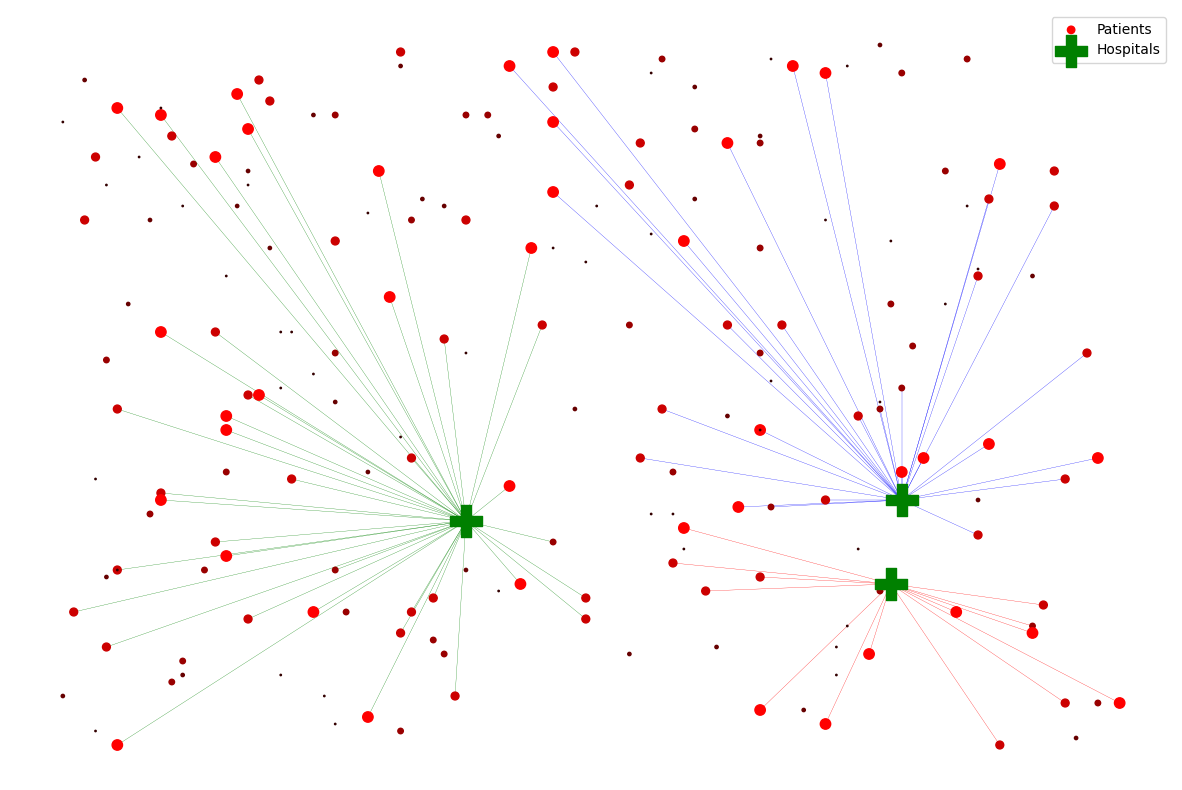

In [8]:
from itertools import cycle

shade_severity = [int(sev*255/5) for sev in patients_severity]
color_severity = ["#%02x0000" % (sev) for sev in shade_severity]
size_severity = [k**2.5 for k in patients_severity]
plt.scatter(*zip(*patients_loc), s=size_severity, c=color_severity, label="Patients", zorder=2)
plt.scatter(*zip(*hospitals_loc), s=500, c="g", marker="P", label="Hospitals", zorder=3)
colors = cycle('bgrcmk')
for i in range(n_hospitals):
  c = next(colors)
  for (x_,y_) in plot_lines[i]:
    plt.plot(x_,y_,c=c,linewidth=0.2, zorder=1)
plt.legend()
plt.axis('off')
plt.show()